<a href="https://colab.research.google.com/github/pranavi-ch/pythonProjects/blob/main/fakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  _*_ encoding: utf-8 _*_
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

#os library contains various file manipulation function
import os

#re- is regex (used in preprocessing and cleaning the data), its very fast to use
import re

#for dealing with textual data such as nlp
import nltk

#for using the gdrive link of the data
import requests
from io import StringIO

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Note- The trains.csv dataset was a dataset that was created in 2016 during the US presidential campaign of Trump and Hillary Clinton. During this time, there was a lot of fake news being circulated, so this data set was given to data scientists to analyse and classify the information into legitimate and fake.

In [ ]:

original_trainURL= "https://drive.google.com/file/d/15a8-3PCoB0N4MPpl3Otg9V4z-x7uyNNo/view?usp=sharing"
file_id= original_trainURL.split('/')[-2]
dwn_url= 'https://drive.google.com/uc?export=download&id=' + file_id

#to get https request from google drive
url= requests.get(dwn_url).text

#to manage data as a file
csv_raw= StringIO(url)

trains= pd.read_csv(csv_raw, encoding ="utf-8")
 
#to print the first few rows of the file
trains.head()
trains['text'][300]


'The Metropolitan Transportation Authority had good news on Monday for subway riders worried about the shutdown of the L train: The closing will be shorter than expected. The authorityâ\x80\x99s board voted to approve a $477 million contract to close the L train tunnel between Brooklyn and Manhattan for 15 months to repair damage caused by Hurricane Sandy  â\x80\x94   instead of 18 months as originally planned. The work is set to begin in April 2019. After several board members raised concerns about a company that was awarded the contract, Judlau Contracting, officials assured the board that the company was the best choice for the project and would finish the work on time. â\x80\x9cI expect this project to be completed in 15 months,â\x80\x9d said Lawrence S. Schwartz, an authority board member. â\x80\x9cI want to make sure that Judlau and everybody else who is going to be involved on this project understands that it will not be tolerated or accepted to be 15 months and one day. â\x80\x

In [ ]:

original_testURL= "https://drive.google.com/file/d/1uDClNNsVfsLN9lwZ8xLTBqrG4u5zH0q4/view?usp=sharing"
file_id= original_testURL.split('/')[-2]
dwn_url= 'https://drive.google.com/uc?export=download&id=' + file_id

#to get https request from google drive
url= requests.get(dwn_url).text

#to manage data as a file
csv_raw= StringIO(url)

test= pd.read_csv(csv_raw)

#to print the first few rows of the file
test.head()


,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. â After years of scorni..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you donât succeed, try a differe..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
#to print the dimensions of the train and test dataset
print(trains.shape, test.shape)   # -> 20800 rows and 5 columns- trains, 5200 rows and 4 columns - test

(20800, 5) (5200, 4)


In [ ]:
#To see the columns present in trains dataset:  
print("The trains data set contains the following columns: ")
for col in trains.columns:
  print(col)
print("--------------------------")
 #to know names of columns in test dataset
for col in test.columns:
  print(col)

#note- label : 1- news is real, else its fake

The trains data set contains the following columns: 
id
title
author
text
label
--------------------------
id
title
author
text


Open Microsoft Excel 2007.
Click on the Data menu bar option.
Click on the From Text icon.
Navigate to the location of the file that you want to import.  Click on the filename and then click on the Import button.  The Text Import Wizard - Step 1 or 3 window will now appear on the screen.
Choose the file type that best describes your data - Delimited or Fixed Width.
Choose 65001: Unicode (UTF-8) from the drop-down list that appears next to File origin.

In [ ]:
print("The right column describes the number of null values for the respective column")

#check the number of null values in trains dataset
print(trains.isnull().sum())
print("-------------------------")
#check the number of null values in trains dataset
print(test.isnull().sum())

The right column describes the number of null values for the respective column
id           0
title      558
author    1957
text        39
label        0
dtype: int64
-------------------------
id          0
title     122
author    503
text        7
dtype: int64


In [ ]:
#first, we will fill the null values with ' ' (space)

trains= trains.fillna(' ')
test= test.fillna(' ')

#check if it worked
print(trains.isnull().sum())

# now we merge the title, author and text columns (text columns) since they are all textual data which is the main focus for assessment and detection
# into a field called 'merged_data'

test['merged_data']= test['title']+' ' +test['author'] +' '+ test['text']
trains['merged_data']= trains['title']+ ' ' +trains['author']+ ' ' + trains['text']
trains['merged_data'].head()


id        0
title     0
author    0
text      0
label     0
dtype: int64


0    House Dem Aide: We Didnât Even See Comeyâs...
1    FLYNN: Hillary Clinton, Big Woman on Campus - ...
2    Why the Truth Might Get You Fired Consortiumne...
3    15 Civilians Killed In Single US Airstrike Hav...
4    Iranian woman jailed for fictional unpublished...
Name: merged_data, dtype: object

**WORDCLOUD VISUALS**

Word clouds or tag clouds are graphical representations of word frequency that give greater prominence to words that appear more frequently in a source text. (source- betterevaluation.org)

This tool is exactly what we need, in order to assess which words have been used more often abd decide whether the news is legitimate or not.

Script used -> pip install wordcloud

Why to use Wordcloud ? 
The dataset trains.csv is a file of huge magnitude (around 50 MB!). This makes it time-consuming to parse through all of the textual data given. Therefore, it becomes necessary to use a package like wordcloud, to make our job simple. 

For a better understanding of the data, we make word clouds.
We make two, one for real news (label-1) 
and one for fake news (label-0) in the label column of the datasets.


In [ ]:
true_words = ''
fake_words = ''
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in trains[trains['label']==1].merged_data:    #to get all the merged_data (title, author, text) from trains which is true (label-1) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    true_words += " ".join(tokens)+" "

for val in trains[trains['label']==0].merged_data:    #to get all the merged data from trains which is false (label-0)
      
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    fake_words += " ".join(tokens)+" "

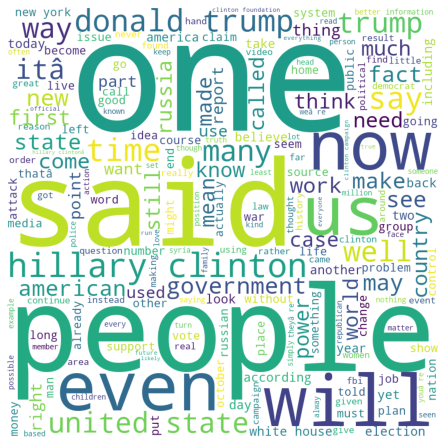

In [ ]:
#to plot the words in with emphasis on the number of recurrences i.e., size of the font of the particular word
# is directly in proportion to the number of times it has occured in the dataset for true news 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(true_words) 
  
# display the wordcloud image                       
plt.figure(figsize = (6, 6), facecolor = None)   
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

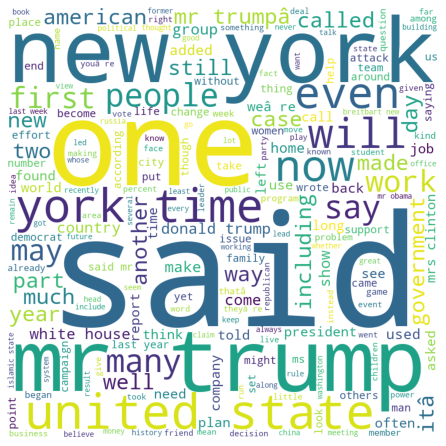

In [ ]:
# generate the same  for fake news also, see which words are recurring for the fake news articles
wordcloud= WordCloud(width=800, height= 800,
                     background_color='white',
                     stopwords=stopwords,
                    min_font_size= 10).generate(fake_words)
#plot using matplotlib

plt.figure(figsize = (6, 6), facecolor = None)   
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()




------Applying data cleansing and preprocessing using the concepts of-------

**Regex, Tokenization, stopwords, lemmatization**

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#the above library has a set of stopword used generally in the English language, printing them:
stop_words= stopwords.words('english')

#download nltk
nltk.download('punkt')
# This tokenizer divides a text into a list of sentences, 
#by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences.
# ... The NLTK data package includes a pre-trained Punkt tokenizer for English. >>>



lemmatizer= WordNetLemmatizer()
#using iterrow method of pandas,
for index,row in trains.iterrows():
  #cleansed_data is the string which will hold the total merged_data of all the rows of the dataset trains.
  cleansed_sentence=''
  #get the sentence ('merged_data')
  original_sentence=  row['merged_data']  #obtain merged_data from the row 
  
  #use regex to remove punctuation 
  original_sentence= re.sub(r'[^\w\s]','',original_sentence)   
  #substitutes everything thats not a word or a space (w\s) with '' and replaces the resulted
  #string in the orginal_sentence variable

  #use string tokenize to seperate the words of the sentence
  words= nltk.word_tokenize(original_sentence)

  #removing stopwords by traversing through the words array
  words=[w for w in words if not w in stop_words]
  #lemmatizing 
  for word in words:
   cleansed_sentence=cleansed_sentence + ' '+  str(lemmatizer.lemmatize(word)).lower()

  #now replace the originial sentence with the cleansed data
  trains.loc[index,'merged_data']= cleansed_sentence

  #Access a group of rows and columns by label(s) or a boolean array. '.loc[]' is primarily label based

  #-------done with data cleansing ------------
print("Data cleansing successful")





[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Data cleansing successful


In [ ]:
#check if data cleansing has worked, by printing the head elements:
trains['merged_data'][2]


' why truth might get you fired consortiumnewscom why truth might get you fired october 29 2016 the tension intelligence analyst political policymakers always honest assessment desired result latter often overwhelming former iraq war writes lawrence davidson by lawrence davidson for might wonder foreign policy maker repeatedly make bad choice insight might drawn following analysis the action play united states lesson probably universal back early spring 2003 george w bush initiated invasion iraq one key public reason claim countryâs dictator saddam hussein verge developing nuclear weapon hiding weapon mass destruction the real reason went beyond charge included longrange plan âregime changeâ middle east president george w bush vice president dick cheney receive oval office briefing cia director george tenet also present chief staff andy card right white house photo for purpose concentrate belief iraq become hostile nuclear power why president bush close associate accept scenario readil

From here on, we will only need the merged_data column and the label column, so we will redefine trains.csv to only these two columns

In [ ]:
trains= trains[['merged_data' , 'label']]
trains.head()


,merged_data,label
0,house dem aide we didnât even see comeyâs let...,1
1,flynn hillary clinton big woman campus breitb...,0
2,why truth might get you fired consortiumnewsc...,1
3,15 civilians killed in single us airstrike ha...,1
4,iranian woman jailed fictional unpublished st...,1


In [ ]:
#for the sake of simplicity and to apply NLP techniques to the data, we create two docs, one for labels, and one for the
#merged data columns

l_trains= trains['label']
md_trains= trains['merged_data']

**NLP TECHNIQUES**

One- hot encoding (each word is stored as a vector of 0's and 1's
each word is stored as a vector in a dictionary

In [ ]:
#importing the libraries required for NLP
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer # works like bag-of-words
from sklearn.feature_extraction.text import TfidfVectorizer

#testing the Packages

sampleText= [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]

#object for CountVectorizer
vectorizer= CountVectorizer()

#makes a dictionary of vectors
#.fit_transform(X) = learn feature names + .transform(X)  (machine doesn't know the words order that we have given)
X= vectorizer.fit_transform(sampleText)
#whenever we use any new text, we should use transform so that machine can learn the text order

#prints the unique words given in the input
print(vectorizer.get_feature_names())

#prints the vector representation (1-hot encoding) of each sentence of sampleText 
print(X.toarray())


['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


**TF-iDF**

(measures the originality of a word by comparing number of times a word appears in a file or doc with the number of docs the word appears in )

to get the essence of the more important words

**Mathematical Formula:  TF-iDF= TF(+,d) * IDF(+)**


TF= term frequency of term '+' in a doc 'd'

IDF= inverse document frequency = ( log( (1+n)/(1+df(d,+)) ) ) +1

n= number of documents the term '+' appears in 


In [ ]:
#an example of implementing TF-iDF vectorization

#max_features-> take only the top weightage words since data is huge
def vectorize_text(features, max_features):
  vectorizer= TfidfVectorizer(stop_words='english',  
                              decode_error= 'strict',  # UnicodeDecodeError will be raised
                              analyzer= 'word' ,
                              ngram_range= (1, 2) ,  #takes 1 token at a time and 2 tokens at a time
                              #If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
                              max_features= max_features)    
  feature_vec= vectorizer.fit_transform(features)
  return feature_vec.toarray()
 
tfidf_features= vectorize_text(['Hello what are you doing', 'Hello I am doing gardening'],30)  #will only display 30 of the top features with max weightage
tfidf_features


array([[0.57735027, 0.        , 0.        , 0.57735027, 0.57735027],
       [0.37930349, 0.53309782, 0.53309782, 0.37930349, 0.37930349]])

Now, we apply TF-iDF to the trains dataset

In [ ]:
#make a countVectorzier object
count_vectorizer= CountVectorizer()
count_vectorizer.fit_transform(md_trains)
freq_term_matrix= count_vectorizer.transform(md_trains)
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix= tfidf.fit_transform(freq_term_matrix)
tf_idf_matrix

<20800x250516 sparse matrix of type '<class 'numpy.float64'>'
	with 6156344 stored elements in Compressed Sparse Row format>

Modelling the data

In [ ]:
test_counts = count_vectorizer.transform(test['merged_data'].values)
test_tfidf = tfidf.transform(test_counts)

#split in samples
#train_test_split allows us to Split arrays or matrices into random train and test subsets
#CLASSIFIER COMPARISON
from sklearn.model_selection import train_test_split
md_trains, md_test, L_trains, L_test = train_test_split(tf_idf_matrix, l_trains, random_state=0)

**Logistic regression** 

Logistic Regression is used when the dependent variable(target) is categorical.

Data is fit into linear regression model, which then be acted upon by a logistic function predicting the target categorical dependent variable.

In [ ]:
#import Logistic Regression from Scikit Lib
from sklearn.linear_model import LogisticRegression

logreg= LogisticRegression(C=1e5)

#fit to a linear logistic regression curve
logreg.fit(md_trains, L_trains)

#predicts the accuracy of the plot
pred= logreg.predict(md_trains)

print('Accuracy achieved by the logistic classifier on the trains dataset: {:.2f}'.format(logreg.score(md_trains,L_trains)))


Accuracy achieved by the logistic classifier on the trains dataset: 1.00


We construct confusion matrix (TN, FP, FN, TP) and calculate the number of each.
Then we use baye's conditional probablity theorom (from sklearn.naive_bayes library , we use **MultinomialNB** ) to calculate the accuracy of the prediction model we have built .

In [ ]:
#import the library 
from sklearn.naive_bayes import MultinomialNB
#The multinomial Naive Bayes classifier is suitable for classification with discrete features 
#precision = (TP) / (TP+FP)
#TP is the number of true positives, and FP is the number of false positives. 

nb= MultinomialNB()
nb.fit(md_trains,L_trains)
pred= nb.predict(md_trains)
print('******Accuracy of NB  classifier on training set: {:.2f} ***********'
     .format(nb.score(md_trains, L_trains)))
cm= confusion_matrix(L_trains,pred)
cm

******Accuracy of NB  classifier on training set: 0.90 ***********


array([[7815,    8],
       [1562, 6215]])

In [ ]:
#to display the results in a user friendly way: 

TN= cm[0][0]
FP= cm[0][1]
FN= cm[1][0]
TP= cm[1][1]
total_samples= TN + FP + FN + TP
print("** IMPORTANT RESULTS **")
print('Total samples used for testing: (from test_train_cases')
print(total_samples)
print('Number of Correct predictions: (True positives+ True Negatives)')
print(TN + TP)
print("Number of Wrong Predictions (False positives+ False negatives")
print(FN + FP)


** IMPORTANT RESULTS **
Total samples used for testing: (from test_train_cases
15600
Number of Correct predictions: (True positives+ True Negatives)
14030
Number of Wrong Predictions (False positives+ False negatives
1570


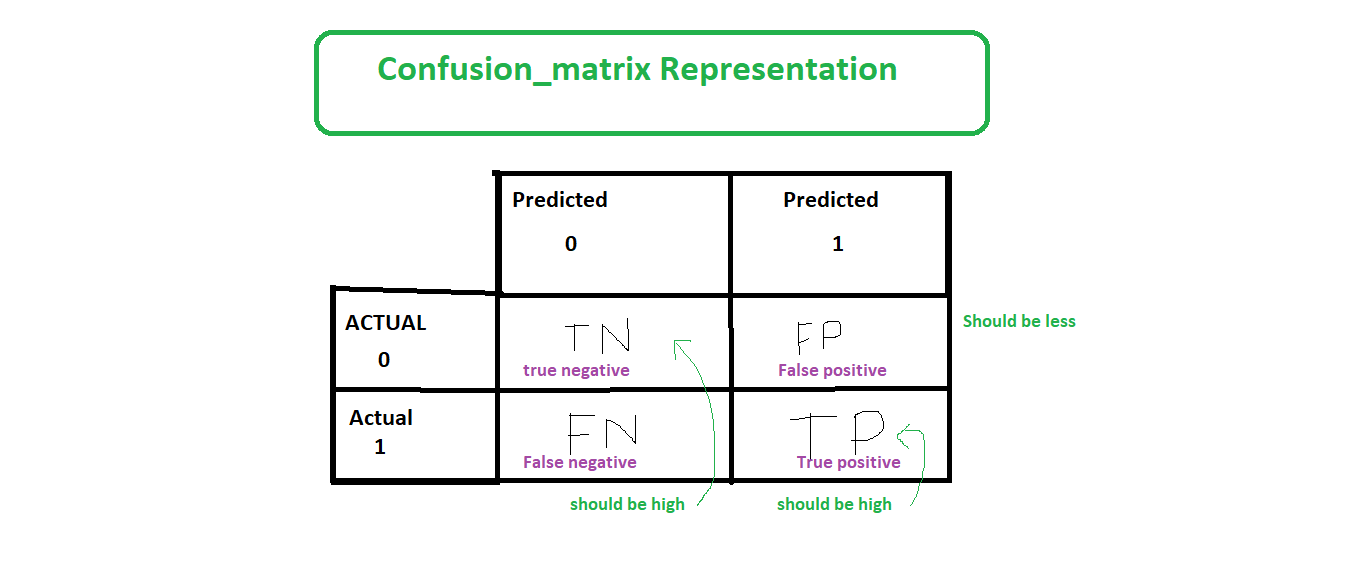

**--------Deployment-----------**

1) **Pipelining**

There are many moving parts in a Machine Learning (ML) model that have to be tied together for an ML model to execute and produce results successfully. This process of tying together different pieces of the ML process is known as a pipeline. 

In [ ]:
#Assiging the variables again as once transformed vectors can't be transformed again using pipeline.

#stores merged data column of the trains dataset
md_trains= trains['merged_data']

#stores the label (1-true, 0-fake) of trains dataset
l_trains= trains['label']


In [ ]:
#importing all the libraries to be used in the pipeline
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#constructing the pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('clf', linear_model.LogisticRegression(C=1e5)),
])

In [ ]:
#fit the pipeline to the data
pipeline.fit(md_trains, l_trains)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1

In [ ]:
#check the pipeline working

print(pipeline.predict([" why truth might get you fired consortiumnewscom why truth might get you fired october 29 2016 the tension intelligence analyst political policymakers always honest assessment desired result latter often overwhelming former iraq war writes lawrence davidson by lawrence davidson for might wonder foreign policy maker repeatedly make bad choice insight might drawn following analysis the action play united states lesson probably universal back early spring 2003 george w bush initiated invasion iraq one key public reason claim countryâs dictator saddam hussein verge developing nuclear weapon hiding weapon mass destruction the real reason went beyond charge included longrange plan âregime changeâ middle east president george w bush vice president dick cheney receive oval office briefing cia director george tenet also present chief staff andy card right white house photo for purpose concentrate belief iraq become hostile nuclear power why president bush close associate accept scenario readily the short answer bush wanted indeed needed believe rationale invading iraq at first tried connect saddam hussein 911 attack us though never gave stratagem lack evidence made difficult rally american people already fixated afghanistan support war baghdad but nuclear weapon gambit proved fruitful hard evidence charge supposedly reliable witness person exiled antisaddam iraqis many us governmentâs payroll kept telling bush adviser nuclear story true what us leadership cadre whose worldview literally demanded mortally dangerous iraq informant order precipitate overthrow saddam willing tell tale pending atomic weapon the strong desire believe tale nuclear iraq lowered threshold proof likewise repeated assertion assumed dependable iraqi source underpinned nationwide us campaign generating fear war fever so us ally insisted united nations send weapon inspector scour iraq evidence nuclear weapon program well chemical biological weapon that inspector could find convincing evidence frustrated bush administration soon forced hand on march 19 2003 bush launched invasion iraq expectation occupation country us inspector would surely find evidence nuke least stockpile chemical biological weapon they their iraqi informant systematically lied social behavioral sciences rescue the various us intelligence agency thoroughly shaken affair today 13 year later director manager still trying sort â specifically tell getting âtrueâ intelligence lied or one intelligence worker put need â help protect u army snake oil salesman â to end cia et al market academic assistance ahmed chalabi head iraqi national congress key supplier iraqi defector bogus story hidden wmd a âpartnershipâ forged office director national intelligence odni serf coordinating center sixteen independent us intelligence agency national academies sciences engineering medicine the result collaboration â permanent intelligence community studies boardâ coordinate program âsocial behavioral science research might strengthen national security â despite effort almost certain âsocial behavioral sciencesâ give spy agency want â way detecting lie better present standard procedure polygraph test interrogation but even could might well make difference real problem found liar it found believer the believers it simply true odni leader seem assert us intelligence agency personnel tell often lied this case thousand middleechelon intelligence worker desk officer specialist know something closely approaching truth â know pretty well going place like afghanistan iraq syria libya israel palestine elsewhere director national intelligence james clapper right talk president barack obama oval office john brennan national security aide present photo credit office director national intelligence therefore someone feed âsnake oilâ usually know however accurate grasp thing often avail superior â got appointment accepting prestructured worldview â different criterion âtrueâ analyst listen charles gaukel national intelligence council â yet another organization act meeting ground 16 intelligence agency referring search way avoid getting taken lie gaukel declared â weâre looking truth but weâre particularly looking truth work â now might mean i certainly tell mean historically it mean power broker âtruthâ must match fit worldview â political ideological precept if fit âworkâ so intelligence specialist send usually accurate assessment line policy maker often hit roadblock caused âgroup thinkâ ideological blinker âwe know betterâ attitude on hand long youâre selling leadership match want believe peddle anything imaginary iraqi nuke israel westernstyle democracy saudi arabia indispensable ally libya liberated country bashar alassad real roadblock peace syria strategic defense initiative sdi aka star wars world getting colder warmer american exceptionalism glory â list almost endless what sad tale tell u if want spend million dollar social behavioral science research improve assessment use intelligence forget liar what want look antidote narrowmindedness believer â policymakers seem able rise ideological presumption class â presumption underpin selfconfidence lead u slippery slope it happened way often many place source shakespeareâs determination âwhat past preludeâ our elite play destiny free â capacity break structured way seeing yet middleechelon specialist keep sending relatively accurate assessment ladder power hope spring eternal"]))


[1]


Note: The above news snipped was copy pasted from the original trains dataset and was labelled to be true, and our output is also showing true. ([1]- implies true)

**Saving the Pipeline**

In [ ]:
#SAV is a file extension used for the saved date of SPSS (Statistical Package for the Social Sciences). 
#SPSS is used for statistical analysis
#SAV files contain binary data which can only be used on the platform that created the file.
filename = 'pipeline.sav'

joblib.dump(pipeline, filename)



['pipeline.sav']

In [ ]:
filename='./pipeline.sav'